In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from shutil import copy
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from shutil import copy
from shutil import rmtree

from keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [2]:
#puts files with numbers in number-named folders
def folder_putter(path, Num):
    Num = str(Num)
    #check is /on the end of path 
    if (path[:-2]!='/'): path = path+'/'
    #check is folder exists, if not - create
    if (os.path.isdir(path+Num)==0):
        os.mkdir(path+Num)
    #find files starting that number and copy it in their folder
    filelist = os.listdir(path)
    for file in filelist:
        if (separ_number_from_filename(file)==Num) and os.path.isfile(path+Num+'/'+file)==0 and file.endswith(".png"):
            copy(path+file, path+Num+'/'+file)
    return 0


def separ_number_from_filename(filename_string):
    pos = len(filename_string)
    for i in range(len(filename_string)):
        if not filename_string[i].isdigit():
            pos = i
            break
    return str(int(filename_string[:pos])) 


#function for: 
    #getting the list of files, 
    #splitting them, 
    #putting files in "training" and "validation" folders, and "categofy_name" folders 
def splitter (Original_Dir, split_ratio, categories_Num):

    type_of_data_files = '.png'

    filelist = []
    for i in os.listdir(Original_Dir):
        if i.endswith(type_of_data_files):
            filelist.append(i)

    categories_Num = 12
    #os.path.join(Original_Dir)
    N_files = len(filelist)
    num_training=int(split_ratio*N_files)

    #shuffling filelist
    random.shuffle(filelist)
    filelist_training = filelist[:num_training]
    filelist_validation = filelist[num_training:]

    #check is "training" and "validation" folder exists, if not - create
    training_dir = os.path.join(Original_Dir, 'training')
    validation_dir = os.path.join(Original_Dir, 'validation')

    if (os.path.isdir(training_dir) ==True):
        rmtree(training_dir) # if exists, deliting the old training folder
    if (os.path.isdir(validation_dir) ==True):
        rmtree(validation_dir) #deliting the old validation folder
    os.mkdir(training_dir) #making new empty
    os.mkdir(validation_dir)

    #for each file in filelist_training, put files in their folders
    DIR = training_dir
    for f in filelist_training:
        #what's it's spoken number?
        num = separ_number_from_filename(f)
        num_folder = os.path.join(DIR, num)
        #if folder for spoken number doesn't exist, make it
        if (os.path.isdir(num_folder) ==0):
            os.mkdir(num_folder)

        copy(os.path.join(Original_Dir, f) #copy from
            , os.path.join(DIR,num,f))       #copy to

    #now for validation    
    #for each file in filelist_validation, put files in their folders
    DIR = validation_dir
    for f in filelist_validation:
        #what's it's spoken number?
        num = separ_number_from_filename(f)
        num_folder = os.path.join(DIR, num)
        #if folder for spoken number doesn't exist, make it
        if (os.path.isdir(num_folder) ==0):
            os.mkdir(num_folder)

        copy(os.path.join(Original_Dir, f), os.path.join(DIR,num,f))      


this code below doesn't need any previous, because it takes images from directory, opens and resize them with *ImageDataGenerator*
But it does need files in the "categofy_name" folders

Need a splitter function for: getting the list of files, splitting them, putting files in "training" and "validation" folders, and  "categofy_name" folders 

In [3]:



Original_Dir = 'C:/Users/verat/Desktop/DS_MeetUp/SpeechRecognition/TestSamples'
training_dir = os.path.join(Original_Dir, 'training')
validation_dir = os.path.join(Original_Dir, 'validation')

split_ratio = 0.9
splitter (Original_Dir, split_ratio, categories_Num=13)


making Batches with ImageDataGenerator 

In [5]:

#TRAINING DATA
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=0,
      width_shift_range=0.0,
      height_shift_range=0.0,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

train_generator = training_datagen.flow_from_directory(
	training_dir,
	target_size=(200,200),
	class_mode='categorical'
)

#VALIDATION DATA
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(
	validation_dir,
	target_size=(200,200),
	class_mode='categorical'
)


Found 647 images belonging to 13 classes.
Found 72 images belonging to 13 classes.


Next part - building the model

In [6]:
model = tf.keras.models.Sequential([
    
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
        # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(13, activation='softmax')
])
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) #usually  optimizer='adam'

history = model.fit_generator(train_generator, epochs=250, validation_data = validation_generator, verbose = 1)

model.save("sp_recog.h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 64)        16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       1

21/21 [==============================] - ETA: 1:08 - loss: 0.2773 - accuracy: 0.90 - ETA: 1:05 - loss: 0.2373 - accuracy: 0.90 - ETA: 1:00 - loss: 0.2582 - accuracy: 0.88 - ETA: 55s - loss: 0.2833 - accuracy: 0.8984 - ETA: 51s - loss: 0.2745 - accuracy: 0.912 - ETA: 48s - loss: 0.2557 - accuracy: 0.916 - ETA: 45s - loss: 0.2667 - accuracy: 0.915 - ETA: 41s - loss: 0.2637 - accuracy: 0.914 - ETA: 38s - loss: 0.2628 - accuracy: 0.909 - ETA: 34s - loss: 0.2620 - accuracy: 0.909 - ETA: 31s - loss: 0.2771 - accuracy: 0.903 - ETA: 28s - loss: 0.2726 - accuracy: 0.901 - ETA: 24s - loss: 0.3028 - accuracy: 0.889 - ETA: 21s - loss: 0.2974 - accuracy: 0.892 - ETA: 18s - loss: 0.2916 - accuracy: 0.895 - ETA: 15s - loss: 0.2858 - accuracy: 0.896 - ETA: 12s - loss: 0.2894 - accuracy: 0.897 - ETA: 9s - loss: 0.2867 - accuracy: 0.901 - ETA: 6s - loss: 0.3013 - accuracy: 0.89 - ETA: 2s - loss: 0.2930 - accuracy: 0.89 - 65s 3s/step - loss: 0.2914 - accuracy: 0.8949 - val_loss: 1.1513 - val_accuracy: 0.

21/21 [==============================] - ETA: 1:04 - loss: 0.0281 - accuracy: 1.00 - ETA: 1:01 - loss: 0.0500 - accuracy: 0.98 - ETA: 57s - loss: 0.0604 - accuracy: 0.9688 - ETA: 53s - loss: 0.0610 - accuracy: 0.976 - ETA: 49s - loss: 0.0516 - accuracy: 0.981 - ETA: 46s - loss: 0.0537 - accuracy: 0.974 - ETA: 43s - loss: 0.0477 - accuracy: 0.977 - ETA: 39s - loss: 0.0484 - accuracy: 0.976 - ETA: 36s - loss: 0.0438 - accuracy: 0.979 - ETA: 31s - loss: 0.0403 - accuracy: 0.979 - ETA: 28s - loss: 0.0368 - accuracy: 0.981 - ETA: 25s - loss: 0.0436 - accuracy: 0.980 - ETA: 22s - loss: 0.0686 - accuracy: 0.974 - ETA: 19s - loss: 0.0664 - accuracy: 0.976 - ETA: 17s - loss: 0.0778 - accuracy: 0.975 - ETA: 14s - loss: 0.0839 - accuracy: 0.971 - ETA: 11s - loss: 0.0811 - accuracy: 0.973 - ETA: 8s - loss: 0.0785 - accuracy: 0.974 - ETA: 5s - loss: 0.0770 - accuracy: 0.97 - ETA: 2s - loss: 0.0767 - accuracy: 0.97 - 63s 3s/step - loss: 0.0786 - accuracy: 0.9753 - val_loss: 1.3660 - val_accuracy: 0.

21/21 [==============================] - ETA: 1:04 - loss: 0.0343 - accuracy: 0.96 - ETA: 1:01 - loss: 0.0669 - accuracy: 0.96 - ETA: 57s - loss: 0.0712 - accuracy: 0.9688 - ETA: 53s - loss: 0.0766 - accuracy: 0.968 - ETA: 49s - loss: 0.0656 - accuracy: 0.975 - ETA: 46s - loss: 0.1167 - accuracy: 0.963 - ETA: 43s - loss: 0.1049 - accuracy: 0.964 - ETA: 39s - loss: 0.0934 - accuracy: 0.968 - ETA: 36s - loss: 0.0856 - accuracy: 0.972 - ETA: 33s - loss: 0.0774 - accuracy: 0.975 - ETA: 30s - loss: 0.0991 - accuracy: 0.974 - ETA: 27s - loss: 0.0917 - accuracy: 0.976 - ETA: 24s - loss: 0.0917 - accuracy: 0.973 - ETA: 20s - loss: 0.0856 - accuracy: 0.975 - ETA: 17s - loss: 0.0806 - accuracy: 0.977 - ETA: 14s - loss: 0.0758 - accuracy: 0.978 - ETA: 11s - loss: 0.0714 - accuracy: 0.978 - ETA: 8s - loss: 0.0676 - accuracy: 0.980 - ETA: 5s - loss: 0.0661 - accuracy: 0.97 - ETA: 2s - loss: 0.0693 - accuracy: 0.97 - 63s 3s/step - loss: 0.0678 - accuracy: 0.9753 - val_loss: 1.1736 - val_accuracy: 0.

21/21 [==============================] - ETA: 1:04 - loss: 0.0012 - accuracy: 1.00 - ETA: 1:01 - loss: 0.0048 - accuracy: 1.00 - ETA: 57s - loss: 0.0212 - accuracy: 1.0000 - ETA: 53s - loss: 0.0499 - accuracy: 0.984 - ETA: 50s - loss: 0.0403 - accuracy: 0.987 - ETA: 46s - loss: 0.0337 - accuracy: 0.989 - ETA: 43s - loss: 0.0429 - accuracy: 0.982 - ETA: 39s - loss: 0.0425 - accuracy: 0.984 - ETA: 36s - loss: 0.0458 - accuracy: 0.982 - ETA: 33s - loss: 0.0418 - accuracy: 0.984 - ETA: 30s - loss: 0.0596 - accuracy: 0.983 - ETA: 27s - loss: 0.0594 - accuracy: 0.981 - ETA: 24s - loss: 0.0609 - accuracy: 0.980 - ETA: 20s - loss: 0.0569 - accuracy: 0.982 - ETA: 17s - loss: 0.0535 - accuracy: 0.983 - ETA: 14s - loss: 0.0504 - accuracy: 0.984 - ETA: 11s - loss: 0.0475 - accuracy: 0.984 - ETA: 8s - loss: 0.0453 - accuracy: 0.985 - ETA: 5s - loss: 0.0446 - accuracy: 0.98 - ETA: 2s - loss: 0.0424 - accuracy: 0.98 - 63s 3s/step - loss: 0.0405 - accuracy: 0.9876 - val_loss: 1.9526 - val_accuracy: 0.

21/21 [==============================] - ETA: 1:03 - loss: 0.3572 - accuracy: 0.93 - ETA: 1:00 - loss: 0.2569 - accuracy: 0.95 - ETA: 57s - loss: 0.1776 - accuracy: 0.9688 - ETA: 53s - loss: 0.1971 - accuracy: 0.960 - ETA: 49s - loss: 0.1578 - accuracy: 0.968 - ETA: 46s - loss: 0.1489 - accuracy: 0.968 - ETA: 43s - loss: 0.1353 - accuracy: 0.968 - ETA: 39s - loss: 0.1227 - accuracy: 0.968 - ETA: 36s - loss: 0.1110 - accuracy: 0.972 - ETA: 33s - loss: 0.1001 - accuracy: 0.975 - ETA: 30s - loss: 0.0911 - accuracy: 0.977 - ETA: 27s - loss: 0.0850 - accuracy: 0.979 - ETA: 24s - loss: 0.0785 - accuracy: 0.980 - ETA: 20s - loss: 0.0764 - accuracy: 0.979 - ETA: 17s - loss: 0.0713 - accuracy: 0.981 - ETA: 14s - loss: 0.0669 - accuracy: 0.982 - ETA: 11s - loss: 0.0629 - accuracy: 0.983 - ETA: 8s - loss: 0.0612 - accuracy: 0.982 - ETA: 5s - loss: 0.0590 - accuracy: 0.98 - ETA: 2s - loss: 0.0561 - accuracy: 0.98 - 62s 3s/step - loss: 0.0540 - accuracy: 0.9845 - val_loss: 1.5745 - val_accuracy: 0.

21/21 [==============================] - ETA: 1:03 - loss: 0.0642 - accuracy: 0.96 - ETA: 1:01 - loss: 0.0322 - accuracy: 0.98 - ETA: 57s - loss: 0.0218 - accuracy: 0.9896 - ETA: 53s - loss: 0.0264 - accuracy: 0.984 - ETA: 42s - loss: 0.0213 - accuracy: 0.985 - ETA: 41s - loss: 0.0216 - accuracy: 0.982 - ETA: 38s - loss: 0.0185 - accuracy: 0.984 - ETA: 36s - loss: 0.0193 - accuracy: 0.987 - ETA: 33s - loss: 0.0199 - accuracy: 0.988 - ETA: 31s - loss: 0.0180 - accuracy: 0.989 - ETA: 28s - loss: 0.0167 - accuracy: 0.990 - ETA: 25s - loss: 0.0153 - accuracy: 0.991 - ETA: 22s - loss: 0.0142 - accuracy: 0.992 - ETA: 19s - loss: 0.0133 - accuracy: 0.992 - ETA: 17s - loss: 0.0124 - accuracy: 0.993 - ETA: 14s - loss: 0.0176 - accuracy: 0.991 - ETA: 11s - loss: 0.0167 - accuracy: 0.992 - ETA: 8s - loss: 0.0171 - accuracy: 0.990 - ETA: 5s - loss: 0.0163 - accuracy: 0.99 - ETA: 2s - loss: 0.0156 - accuracy: 0.99 - 63s 3s/step - loss: 0.0149 - accuracy: 0.9923 - val_loss: 1.2156 - val_accuracy: 0.

Epoch 111/250
21/21 [==============================] - ETA: 1:04 - loss: 2.1580e-04 - accuracy: 1.00 - ETA: 1:01 - loss: 8.8146e-04 - accuracy: 1.00 - ETA: 57s - loss: 7.3811e-04 - accuracy: 1.0000 - ETA: 53s - loss: 5.7152e-04 - accuracy: 1.000 - ETA: 49s - loss: 0.0256 - accuracy: 0.9937    - ETA: 46s - loss: 0.0213 - accuracy: 0.994 - ETA: 42s - loss: 0.0189 - accuracy: 0.995 - ETA: 39s - loss: 0.0169 - accuracy: 0.996 - ETA: 36s - loss: 0.0150 - accuracy: 0.996 - ETA: 33s - loss: 0.0142 - accuracy: 0.996 - ETA: 30s - loss: 0.0129 - accuracy: 0.997 - ETA: 27s - loss: 0.0119 - accuracy: 0.997 - ETA: 23s - loss: 0.0204 - accuracy: 0.995 - ETA: 20s - loss: 0.0192 - accuracy: 0.995 - ETA: 17s - loss: 0.0179 - accuracy: 0.995 - ETA: 14s - loss: 0.0168 - accuracy: 0.995 - ETA: 11s - loss: 0.0162 - accuracy: 0.996 - ETA: 8s - loss: 0.0153 - accuracy: 0.996 - ETA: 5s - loss: 0.0145 - accuracy: 0.99 - ETA: 2s - loss: 0.0138 - accuracy: 0.99 - 63s 3s/step - loss: 0.0132 - accuracy: 0.9969 - v

Epoch 119/250
21/21 [==============================] - ETA: 1:04 - loss: 1.6545e-05 - accuracy: 1.00 - ETA: 1:01 - loss: 1.5112e-05 - accuracy: 1.00 - ETA: 57s - loss: 2.4737e-04 - accuracy: 1.0000 - ETA: 53s - loss: 0.0292 - accuracy: 0.9922    - ETA: 50s - loss: 0.0253 - accuracy: 0.993 - ETA: 46s - loss: 0.0226 - accuracy: 0.994 - ETA: 43s - loss: 0.0194 - accuracy: 0.995 - ETA: 39s - loss: 0.0274 - accuracy: 0.992 - ETA: 36s - loss: 0.0254 - accuracy: 0.993 - ETA: 33s - loss: 0.0232 - accuracy: 0.993 - ETA: 30s - loss: 0.0213 - accuracy: 0.994 - ETA: 27s - loss: 0.0198 - accuracy: 0.994 - ETA: 24s - loss: 0.0190 - accuracy: 0.995 - ETA: 20s - loss: 0.0177 - accuracy: 0.995 - ETA: 17s - loss: 0.0165 - accuracy: 0.995 - ETA: 14s - loss: 0.0156 - accuracy: 0.996 - ETA: 11s - loss: 0.0147 - accuracy: 0.996 - ETA: 8s - loss: 0.0139 - accuracy: 0.996 - ETA: 5s - loss: 0.0131 - accuracy: 0.99 - ETA: 2s - loss: 0.0177 - accuracy: 0.99 - 63s 3s/step - loss: 0.0171 - accuracy: 0.9954 - val_l

Epoch 127/250
21/21 [==============================] - ETA: 1:04 - loss: 9.3878e-07 - accuracy: 1.00 - ETA: 1:01 - loss: 8.5156e-06 - accuracy: 1.00 - ETA: 57s - loss: 0.0024 - accuracy: 1.0000     - ETA: 53s - loss: 0.0024 - accuracy: 1.000 - ETA: 49s - loss: 0.0019 - accuracy: 1.000 - ETA: 46s - loss: 0.0016 - accuracy: 1.000 - ETA: 43s - loss: 0.0301 - accuracy: 0.995 - ETA: 40s - loss: 0.0340 - accuracy: 0.992 - ETA: 36s - loss: 0.0302 - accuracy: 0.993 - ETA: 33s - loss: 0.0295 - accuracy: 0.990 - ETA: 28s - loss: 0.0268 - accuracy: 0.990 - ETA: 25s - loss: 0.0247 - accuracy: 0.991 - ETA: 22s - loss: 0.0228 - accuracy: 0.992 - ETA: 20s - loss: 0.0212 - accuracy: 0.992 - ETA: 17s - loss: 0.0199 - accuracy: 0.993 - ETA: 14s - loss: 0.0186 - accuracy: 0.993 - ETA: 11s - loss: 0.0176 - accuracy: 0.994 - ETA: 8s - loss: 0.0182 - accuracy: 0.992 - ETA: 5s - loss: 0.0173 - accuracy: 0.99 - ETA: 2s - loss: 0.0164 - accuracy: 0.99 - 63s 3s/step - loss: 0.0162 - accuracy: 0.9938 - val_loss:

Epoch 135/250
21/21 [==============================] - ETA: 1:04 - loss: 2.8089e-06 - accuracy: 1.00 - ETA: 1:01 - loss: 0.0013 - accuracy: 1.0000   - ETA: 57s - loss: 0.0010 - accuracy: 1.0000 - ETA: 53s - loss: 9.0838e-04 - accuracy: 1.000 - ETA: 49s - loss: 7.3193e-04 - accuracy: 1.000 - ETA: 46s - loss: 6.3058e-04 - accuracy: 1.000 - ETA: 43s - loss: 6.3012e-04 - accuracy: 1.000 - ETA: 36s - loss: 5.5138e-04 - accuracy: 1.000 - ETA: 33s - loss: 0.0019 - accuracy: 1.0000    - ETA: 31s - loss: 0.0018 - accuracy: 1.000 - ETA: 28s - loss: 0.0020 - accuracy: 1.000 - ETA: 25s - loss: 0.0020 - accuracy: 1.000 - ETA: 22s - loss: 0.0020 - accuracy: 1.000 - ETA: 19s - loss: 0.0034 - accuracy: 1.000 - ETA: 17s - loss: 0.0032 - accuracy: 1.000 - ETA: 14s - loss: 0.0170 - accuracy: 0.997 - ETA: 11s - loss: 0.0160 - accuracy: 0.998 - ETA: 8s - loss: 0.0151 - accuracy: 0.998 - ETA: 5s - loss: 0.0144 - accuracy: 0.99 - ETA: 2s - loss: 0.0145 - accuracy: 0.99 - 63s 3s/step - loss: 0.0139 - accuracy

Epoch 143/250
21/21 [==============================] - ETA: 1:05 - loss: 0.0017 - accuracy: 1.00 - ETA: 1:01 - loss: 0.0012 - accuracy: 1.00 - ETA: 57s - loss: 9.5174e-04 - accuracy: 1.000 - ETA: 53s - loss: 0.0166 - accuracy: 0.9922    - ETA: 50s - loss: 0.0133 - accuracy: 0.993 - ETA: 46s - loss: 0.0112 - accuracy: 0.994 - ETA: 43s - loss: 0.0292 - accuracy: 0.991 - ETA: 39s - loss: 0.0259 - accuracy: 0.992 - ETA: 36s - loss: 0.0259 - accuracy: 0.989 - ETA: 33s - loss: 0.0238 - accuracy: 0.990 - ETA: 30s - loss: 0.0220 - accuracy: 0.991 - ETA: 27s - loss: 0.0201 - accuracy: 0.992 - ETA: 24s - loss: 0.0211 - accuracy: 0.990 - ETA: 20s - loss: 0.0198 - accuracy: 0.991 - ETA: 17s - loss: 0.0193 - accuracy: 0.991 - ETA: 14s - loss: 0.0181 - accuracy: 0.992 - ETA: 11s - loss: 0.0170 - accuracy: 0.992 - ETA: 8s - loss: 0.0253 - accuracy: 0.989 - ETA: 5s - loss: 0.0241 - accuracy: 0.98 - ETA: 2s - loss: 0.0271 - accuracy: 0.98 - 63s 3s/step - loss: 0.0259 - accuracy: 0.9892 - val_loss: 1.04

Epoch 151/250
21/21 [==============================] - ETA: 1:04 - loss: 0.0247 - accuracy: 0.96 - ETA: 1:01 - loss: 0.0125 - accuracy: 0.98 - ETA: 57s - loss: 0.0084 - accuracy: 0.9896 - ETA: 53s - loss: 0.0064 - accuracy: 0.992 - ETA: 49s - loss: 0.0053 - accuracy: 0.993 - ETA: 46s - loss: 0.0045 - accuracy: 0.994 - ETA: 42s - loss: 0.0105 - accuracy: 0.991 - ETA: 39s - loss: 0.0093 - accuracy: 0.992 - ETA: 33s - loss: 0.0083 - accuracy: 0.992 - ETA: 31s - loss: 0.0076 - accuracy: 0.993 - ETA: 28s - loss: 0.0070 - accuracy: 0.993 - ETA: 25s - loss: 0.0064 - accuracy: 0.994 - ETA: 22s - loss: 0.0060 - accuracy: 0.994 - ETA: 19s - loss: 0.0056 - accuracy: 0.995 - ETA: 17s - loss: 0.0052 - accuracy: 0.995 - ETA: 14s - loss: 0.0049 - accuracy: 0.995 - ETA: 11s - loss: 0.0047 - accuracy: 0.996 - ETA: 8s - loss: 0.0072 - accuracy: 0.994 - ETA: 5s - loss: 0.0068 - accuracy: 0.99 - ETA: 2s - loss: 0.0167 - accuracy: 0.99 - 63s 3s/step - loss: 0.0204 - accuracy: 0.9907 - val_loss: 1.5692 - va

Epoch 159/250
21/21 [==============================] - ETA: 1:04 - loss: 5.0976e-05 - accuracy: 1.00 - ETA: 1:01 - loss: 0.0116 - accuracy: 1.0000   - ETA: 57s - loss: 0.0156 - accuracy: 0.9896 - ETA: 53s - loss: 0.0122 - accuracy: 0.992 - ETA: 49s - loss: 0.0101 - accuracy: 0.993 - ETA: 46s - loss: 0.0668 - accuracy: 0.989 - ETA: 42s - loss: 0.0573 - accuracy: 0.991 - ETA: 39s - loss: 0.0505 - accuracy: 0.992 - ETA: 36s - loss: 0.0453 - accuracy: 0.993 - ETA: 33s - loss: 0.0408 - accuracy: 0.993 - ETA: 30s - loss: 0.0375 - accuracy: 0.994 - ETA: 27s - loss: 0.0344 - accuracy: 0.994 - ETA: 23s - loss: 0.0318 - accuracy: 0.995 - ETA: 20s - loss: 0.0295 - accuracy: 0.995 - ETA: 17s - loss: 0.0276 - accuracy: 0.995 - ETA: 14s - loss: 0.0281 - accuracy: 0.993 - ETA: 11s - loss: 0.0265 - accuracy: 0.994 - ETA: 8s - loss: 0.0250 - accuracy: 0.994 - ETA: 5s - loss: 0.0237 - accuracy: 0.99 - ETA: 2s - loss: 0.0228 - accuracy: 0.99 - 63s 3s/step - loss: 0.0217 - accuracy: 0.9954 - val_loss: 2.5

21/21 [==============================] - ETA: 1:04 - loss: 0.0031 - accuracy: 1.00 - ETA: 1:01 - loss: 0.0191 - accuracy: 0.98 - ETA: 57s - loss: 0.0128 - accuracy: 0.9896 - ETA: 53s - loss: 0.0284 - accuracy: 0.976 - ETA: 50s - loss: 0.0264 - accuracy: 0.981 - ETA: 46s - loss: 0.0220 - accuracy: 0.984 - ETA: 43s - loss: 0.0272 - accuracy: 0.982 - ETA: 40s - loss: 0.0238 - accuracy: 0.984 - ETA: 36s - loss: 0.0212 - accuracy: 0.986 - ETA: 33s - loss: 0.0191 - accuracy: 0.987 - ETA: 30s - loss: 0.0174 - accuracy: 0.988 - ETA: 27s - loss: 0.0160 - accuracy: 0.989 - ETA: 24s - loss: 0.0148 - accuracy: 0.990 - ETA: 20s - loss: 0.0137 - accuracy: 0.991 - ETA: 17s - loss: 0.0128 - accuracy: 0.991 - ETA: 14s - loss: 0.0120 - accuracy: 0.992 - ETA: 11s - loss: 0.0113 - accuracy: 0.992 - ETA: 8s - loss: 0.0107 - accuracy: 0.993 - ETA: 5s - loss: 0.0102 - accuracy: 0.99 - ETA: 2s - loss: 0.0097 - accuracy: 0.99 - 63s 3s/step - loss: 0.0094 - accuracy: 0.9938 - val_loss: 1.9170 - val_accuracy: 0.

Epoch 188/250
21/21 [==============================] - ETA: 1:04 - loss: 4.2657e-06 - accuracy: 1.00 - ETA: 1:01 - loss: 7.8487e-04 - accuracy: 1.00 - ETA: 57s - loss: 0.0129 - accuracy: 0.9896     - ETA: 53s - loss: 0.0101 - accuracy: 0.992 - ETA: 49s - loss: 0.0081 - accuracy: 0.993 - ETA: 46s - loss: 0.0068 - accuracy: 0.994 - ETA: 43s - loss: 0.0553 - accuracy: 0.986 - ETA: 39s - loss: 0.0484 - accuracy: 0.988 - ETA: 36s - loss: 0.0431 - accuracy: 0.989 - ETA: 33s - loss: 0.0388 - accuracy: 0.990 - ETA: 30s - loss: 0.0353 - accuracy: 0.991 - ETA: 27s - loss: 0.0324 - accuracy: 0.992 - ETA: 23s - loss: 0.0299 - accuracy: 0.992 - ETA: 20s - loss: 0.0277 - accuracy: 0.993 - ETA: 17s - loss: 0.0595 - accuracy: 0.991 - ETA: 14s - loss: 0.0558 - accuracy: 0.992 - ETA: 11s - loss: 0.0525 - accuracy: 0.992 - ETA: 8s - loss: 0.0496 - accuracy: 0.993 - ETA: 5s - loss: 0.0470 - accuracy: 0.99 - ETA: 2s - loss: 0.0446 - accuracy: 0.99 - 62s 3s/step - loss: 0.0426 - accuracy: 0.9938 - val_loss:

21/21 [==============================] - ETA: 1:04 - loss: 0.0035 - accuracy: 1.00 - ETA: 1:01 - loss: 0.0069 - accuracy: 1.00 - ETA: 58s - loss: 0.0048 - accuracy: 1.0000 - ETA: 54s - loss: 0.0238 - accuracy: 0.992 - ETA: 50s - loss: 0.0202 - accuracy: 0.993 - ETA: 47s - loss: 0.0179 - accuracy: 0.994 - ETA: 43s - loss: 0.0154 - accuracy: 0.995 - ETA: 40s - loss: 0.0135 - accuracy: 0.996 - ETA: 37s - loss: 0.0120 - accuracy: 0.996 - ETA: 33s - loss: 0.0108 - accuracy: 0.996 - ETA: 30s - loss: 0.0100 - accuracy: 0.997 - ETA: 27s - loss: 0.0109 - accuracy: 0.997 - ETA: 24s - loss: 0.0100 - accuracy: 0.997 - ETA: 21s - loss: 0.0093 - accuracy: 0.997 - ETA: 17s - loss: 0.0087 - accuracy: 0.997 - ETA: 14s - loss: 0.0082 - accuracy: 0.997 - ETA: 11s - loss: 0.0077 - accuracy: 0.998 - ETA: 8s - loss: 0.0072 - accuracy: 0.998 - ETA: 5s - loss: 0.0069 - accuracy: 0.99 - ETA: 2s - loss: 0.0065 - accuracy: 0.99 - 63s 3s/step - loss: 0.0062 - accuracy: 0.9985 - val_loss: 2.3021 - val_accuracy: 0.

21/21 [==============================] - ETA: 1:04 - loss: 2.4737e-06 - accuracy: 1.00 - ETA: 1:01 - loss: 1.3113e-06 - accuracy: 1.00 - ETA: 57s - loss: 0.0145 - accuracy: 0.9896     - ETA: 53s - loss: 0.0109 - accuracy: 0.992 - ETA: 49s - loss: 0.0090 - accuracy: 0.993 - ETA: 46s - loss: 0.0075 - accuracy: 0.994 - ETA: 43s - loss: 0.0064 - accuracy: 0.995 - ETA: 39s - loss: 0.0249 - accuracy: 0.992 - ETA: 36s - loss: 0.0231 - accuracy: 0.993 - ETA: 33s - loss: 0.0208 - accuracy: 0.993 - ETA: 30s - loss: 0.0190 - accuracy: 0.994 - ETA: 27s - loss: 0.0174 - accuracy: 0.994 - ETA: 24s - loss: 0.0161 - accuracy: 0.995 - ETA: 20s - loss: 0.0176 - accuracy: 0.993 - ETA: 17s - loss: 0.0164 - accuracy: 0.993 - ETA: 14s - loss: 0.0323 - accuracy: 0.991 - ETA: 11s - loss: 0.0305 - accuracy: 0.992 - ETA: 8s - loss: 0.0288 - accuracy: 0.992 - ETA: 5s - loss: 0.0278 - accuracy: 0.99 - ETA: 2s - loss: 0.0265 - accuracy: 0.99 - 62s 3s/step - loss: 0.0253 - accuracy: 0.9938 - val_loss: 1.8722 - val_

21/21 [==============================] - ETA: 1:07 - loss: 1.3366e-05 - accuracy: 1.00 - ETA: 1:04 - loss: 6.8971e-06 - accuracy: 1.00 - ETA: 59s - loss: 4.8812e-06 - accuracy: 1.0000 - ETA: 55s - loss: 2.1303e-05 - accuracy: 1.000 - ETA: 51s - loss: 2.4470e-05 - accuracy: 1.000 - ETA: 48s - loss: 2.5923e-05 - accuracy: 1.000 - ETA: 44s - loss: 3.0077e-05 - accuracy: 1.000 - ETA: 41s - loss: 2.7799e-05 - accuracy: 1.000 - ETA: 38s - loss: 2.4752e-05 - accuracy: 1.000 - ETA: 34s - loss: 2.3844e-05 - accuracy: 1.000 - ETA: 31s - loss: 2.5121e-05 - accuracy: 1.000 - ETA: 28s - loss: 2.3115e-05 - accuracy: 1.000 - ETA: 25s - loss: 2.1575e-05 - accuracy: 1.000 - ETA: 21s - loss: 2.0763e-05 - accuracy: 1.000 - ETA: 18s - loss: 1.9394e-05 - accuracy: 1.000 - ETA: 15s - loss: 3.9233e-05 - accuracy: 1.000 - ETA: 12s - loss: 0.0145 - accuracy: 0.9963    - ETA: 9s - loss: 0.0145 - accuracy: 0.996 - ETA: 6s - loss: 0.0138 - accuracy: 0.99 - ETA: 2s - loss: 0.0131 - accuracy: 0.99 - 65s 3s/step - l

21/21 [==============================] - ETA: 1:07 - loss: 2.8683e-04 - accuracy: 1.00 - ETA: 1:05 - loss: 1.4571e-04 - accuracy: 1.00 - ETA: 59s - loss: 1.3059e-04 - accuracy: 1.0000 - ETA: 55s - loss: 1.0088e-04 - accuracy: 1.000 - ETA: 51s - loss: 8.3180e-05 - accuracy: 1.000 - ETA: 48s - loss: 5.1325e-04 - accuracy: 1.000 - ETA: 44s - loss: 4.4002e-04 - accuracy: 1.000 - ETA: 41s - loss: 3.8503e-04 - accuracy: 1.000 - ETA: 38s - loss: 3.5659e-04 - accuracy: 1.000 - ETA: 32s - loss: 0.0067 - accuracy: 1.0000    - ETA: 29s - loss: 0.0061 - accuracy: 1.000 - ETA: 26s - loss: 0.0083 - accuracy: 0.997 - ETA: 23s - loss: 0.0077 - accuracy: 0.997 - ETA: 20s - loss: 0.0071 - accuracy: 0.997 - ETA: 17s - loss: 0.0067 - accuracy: 0.997 - ETA: 14s - loss: 0.0064 - accuracy: 0.997 - ETA: 11s - loss: 0.0060 - accuracy: 0.998 - ETA: 8s - loss: 0.0057 - accuracy: 0.998 - ETA: 5s - loss: 0.0054 - accuracy: 0.99 - ETA: 2s - loss: 0.0191 - accuracy: 0.99 - 65s 3s/step - loss: 0.0229 - accuracy: 0.99

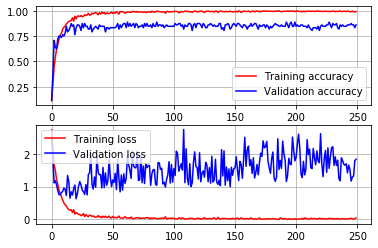

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.subplot(2,1,1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.legend(loc=0)
plt.grid()
plt.subplot(2,1,2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend(loc=0)
plt.grid()
plt.savefig('250epochs', bbox_inches="tight")
plt.show()

In [15]:
np.mean(val_acc[18:22])

0.8298611

In [17]:
testing_dir = os.path.join(Original_Dir, 'validation')
Folders = os.listdir(testing_dir)
for folder in Folders:
    files = os.listdir(os.path.join(Original_Dir, 'validation',folder))
    for file in files:
    #file = files[0]
        img = image.load_img(os.path.join(Original_Dir, 'validation',folder,file), target_size=(200, 200))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        prediction = model.predict(x, batch_size=1)
        pred_ans = Folders[prediction.argmax()]
        print('filename: {}, spoken number: {}, predicted as: {}'.format (file[:-4], separ_number_from_filename(file), pred_ans))

filename: 00_506534a894.wav, spoken number: 0, predicted as: 0
filename: 00_7848934073.wav, spoken number: 0, predicted as: 3
filename: 00_b7608b5131.wav, spoken number: 0, predicted as: 0
filename: 00_bc00a67301.wav, spoken number: 0, predicted as: 0
filename: 01_0682422500.wav, spoken number: 1, predicted as: 4
filename: 01_70a834065c.wav, spoken number: 1, predicted as: 1
filename: 01_71c53373a1.wav, spoken number: 1, predicted as: 1
filename: 01_959ab637a7.wav, spoken number: 1, predicted as: 1
filename: 01_b898452232.wav, spoken number: 1, predicted as: 1
filename: 01_bc99a22049.wav, spoken number: 1, predicted as: 2
filename: 10_2303986452.wav, spoken number: 10, predicted as: 10
filename: 10_7463cb07c3.wav, spoken number: 10, predicted as: 9
filename: 10_9aa2093a96.wav, spoken number: 10, predicted as: 10
filename: 10_a169144267.wav, spoken number: 10, predicted as: 10
filename: 11_08cca30b2c.wav, spoken number: 11, predicted as: 1
filename: 11_0b395c663a.wav, spoken number: 11,